<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Part.3/8.SARIMAX_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 예제 8-1. SARIMAX 모델 예시

### 대중교통 이용자 수 데이터 SARIMAX 모델 적합

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/Metro_Interstate_Traffic_Volume.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M', errors='coerce')
df['Date'] = df['date_time'].dt.date
df =  df[(pd.to_datetime(df['Date']).dt.year > 2015) & (pd.to_datetime(df['Date']).dt.year < 2018)]
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,Date
20344,New Years Day,265.94,0.0,0.0,90,Haze,haze,2016-01-01 00:00:00,1513,2016-01-01
20345,New Years Day,265.94,0.0,0.0,90,Snow,light snow,2016-01-01 00:00:00,1513,2016-01-01
20346,None,266.00,0.0,0.0,90,Snow,light snow,2016-01-01 01:00:00,1550,2016-01-01
20347,None,266.01,0.0,0.0,90,Snow,light snow,2016-01-01 03:00:00,719,2016-01-01
20348,None,264.80,0.0,0.0,90,Clouds,overcast clouds,2016-01-01 04:00:00,533,2016-01-01
...,...,...,...,...,...,...,...,...,...,...
40250,None,249.84,0.0,0.0,1,Clear,sky is clear,2017-12-31 19:00:00,2995,2017-12-31
40251,None,249.79,0.0,0.0,5,Clear,sky is clear,2017-12-31 20:00:00,2731,2017-12-31
40252,None,249.61,0.0,0.0,5,Clear,sky is clear,2017-12-31 21:00:00,2483,2017-12-31
40253,None,249.50,0.0,0.0,1,Clear,sky is clear,2017-12-31 22:00:00,2041,2017-12-31


#### 일별 데이터로의 전처리

In [3]:
df_daily = df.groupby('Date').agg({
    'traffic_volume': lambda x: x.sum() / 1e3,
    'temp': 'mean',
    'holiday': lambda x: (x != 'None').any()
}).reset_index()

df_daily['Day_Type'] = np.where(
    df_daily['holiday'], 'holiday',
    np.where(pd.to_datetime(df_daily['Date']).dt.weekday.isin([0, 1, 2, 3, 4]), 'Weekday', 'Weekend')
)

df_daily.index = df_daily['Date'].values
df_daily = df_daily[['traffic_volume', 'temp', 'Day_Type']]
df_daily

,traffic_volume,temp,Day_Type
2016-01-01,34.489,267.030526,holiday
2016-01-02,41.018,267.002778,Weekend
2016-01-03,28.628,270.056154,Weekend
2016-01-04,81.891,263.121905,Weekday
2016-01-05,61.120,269.139412,Weekday
...,...,...,...
2017-12-27,78.304,253.522083,Weekday
2017-12-28,139.384,258.722826,Weekday
2017-12-29,97.196,255.747586,Weekday
2017-12-30,59.402,250.174167,Weekend


#### 데이터 시각화

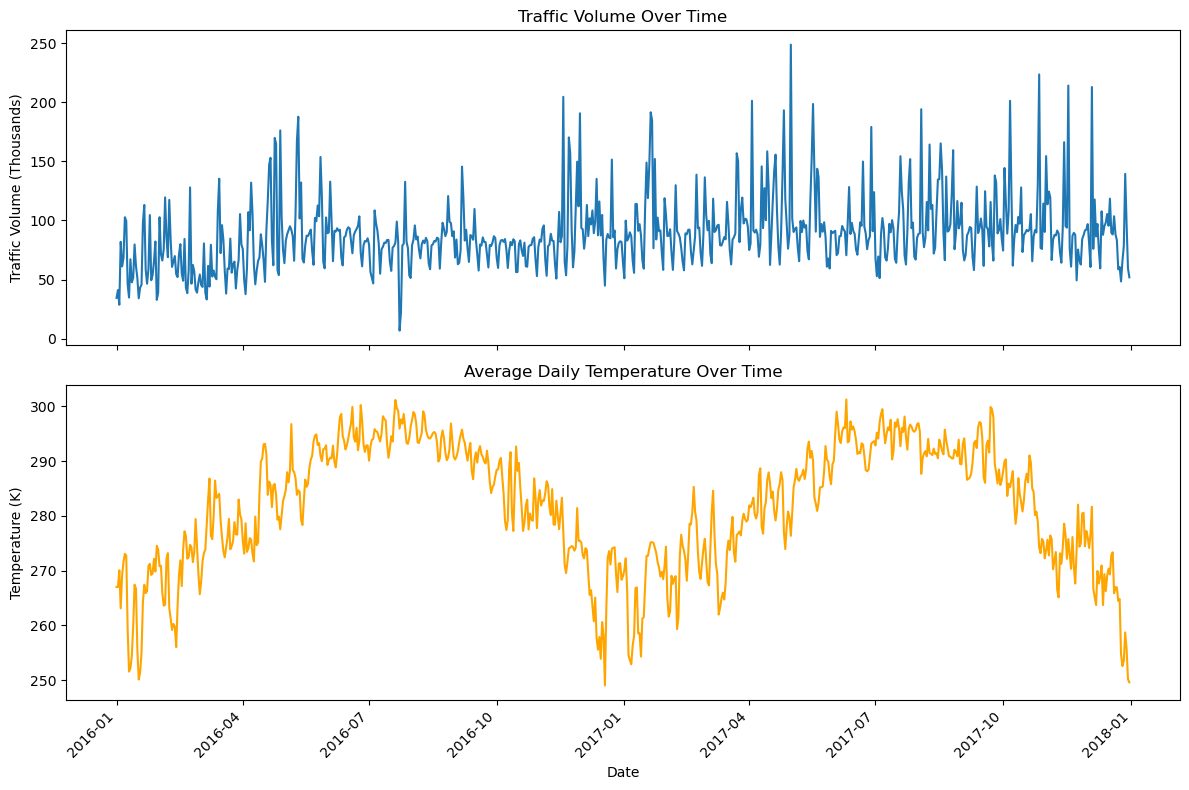

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(df_daily['traffic_volume'], label='Demand')
ax1.set_ylabel('Traffic Volume (Thousands)')
ax1.set_title('Traffic Volume Over Time')

ax2.plot(df_daily['temp'], label='Temperature', color='orange')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Average Daily Temperature Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 외생 변수 영향 분석

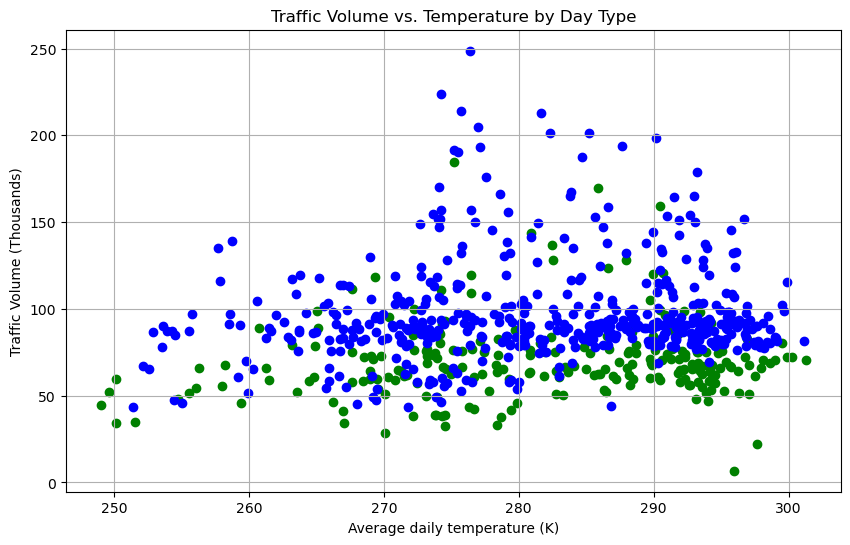

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(df_daily[df_daily["Day_Type"] != 'Weekday']["temp"], df_daily[df_daily["Day_Type"] != 'Weekday']["traffic_volume"], color="g", label="Playday")
plt.scatter(df_daily[df_daily["Day_Type"] == 'Weekday']["temp"], df_daily[df_daily["Day_Type"] == 'Weekday']["traffic_volume"], color="b", label="Weekday")

plt.xlabel('Average daily temperature (K)')
plt.ylabel('Traffic Volume (Thousands)')
plt.title('Traffic Volume vs. Temperature by Day Type')

plt.grid(True)
plt.show()

#### Adfuller test

In [6]:
print(adfuller(df_daily["traffic_volume"][:-9])[1])

0.04088097909932575


#### 이차항 생성

In [7]:
X = pd.DataFrame()
X['Temperature'] = df_daily['temp']
X["Temperature^2"] = df_daily["temp"] ** 2
X["Weekday"] = (df_daily['Day_Type'] == 'Weekday').astype(int)

#### SARIMA 파라미터 최적화 함수

In [8]:
def SARIMAX_optimizer(y, X):
    result= []
    for p in range(4):
        for q in range(4):
            for P in range(6):
                for Q in range(6-P):
                    try:
                        model = SARIMAX(y, X, order=(p, 1, q), simple_differencing=False, seasonal_order=(P, 0, Q, 7)).fit(dips=False)
                    except:
                        continue

                    aic = model.aic
                    result.append([p, q, P, Q, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'q', 'P', 'Q', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

#### 오차 차수 최적화

In [9]:
result = SARIMAX_optimizer(df_daily["traffic_volume"][:-9], X[:-9])
result

,p,q,P,Q,AIC
0,0,2,3,0,6653.776411
1,1,1,3,0,6656.898512
2,0,2,0,3,6656.912777
3,0,2,0,0,6656.915795
4,0,3,3,0,6657.364945
...,...,...,...,...,...
331,0,0,2,0,6978.111958
332,0,0,0,2,6978.146377
333,0,0,1,1,6978.594018
334,0,0,2,1,6980.132012


#### SARIMAX 모델 적합

In [10]:
model = SARIMAX(df_daily["traffic_volume"][:-9], exog=X[:-9], order=(0, 1, 2), simple_differencing=False, seasonal_order=(3, 0, 0, 7))
fit = model.fit(disp=False)
print(fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                  722
Model:             SARIMAX(0, 1, 2)x(3, 0, [], 7)   Log Likelihood               -3317.888
Date:                            Tue, 25 Feb 2025   AIC                           6653.776
Time:                                    21:12:52   BIC                           6695.002
Sample:                                01-01-2016   HQIC                          6669.691
                                     - 12-22-2017                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Temperature      24.1286      6.762      3.568      0.000      10.875      37.382
Temperature^2    -0.0431  

#### 잔차 확인

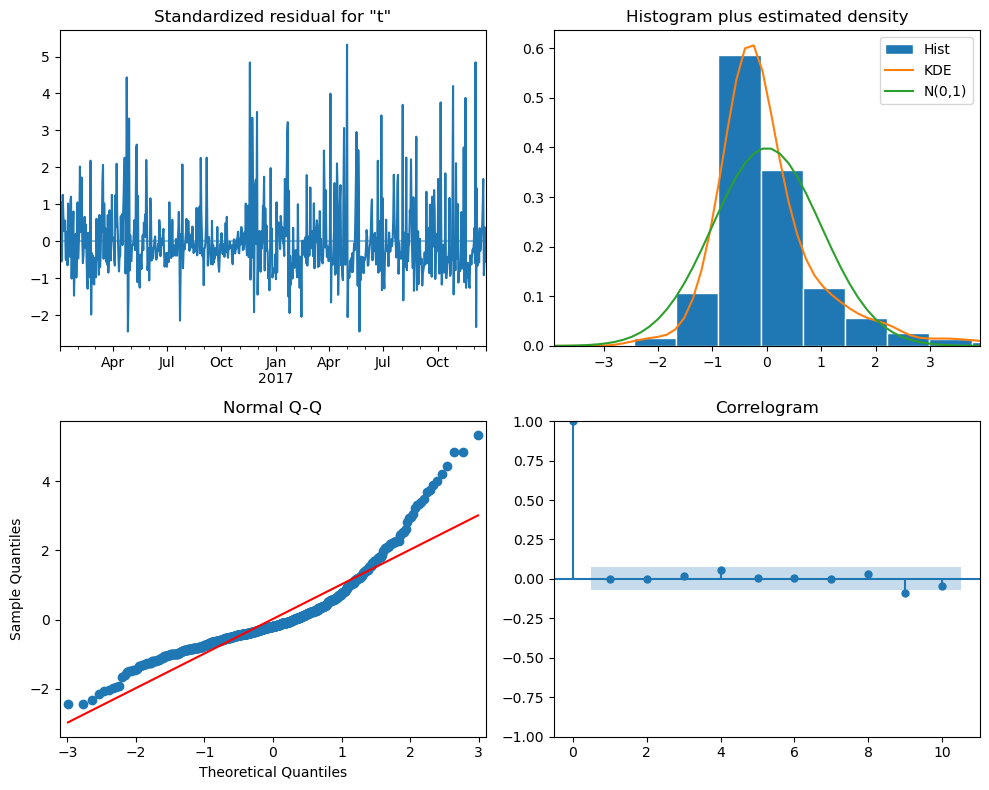

In [11]:
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

#### SARIMAX 예측

In [12]:
forecast_result = fit.get_forecast(steps=9, exog=X[-9:])
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]

#### 예측 시각화

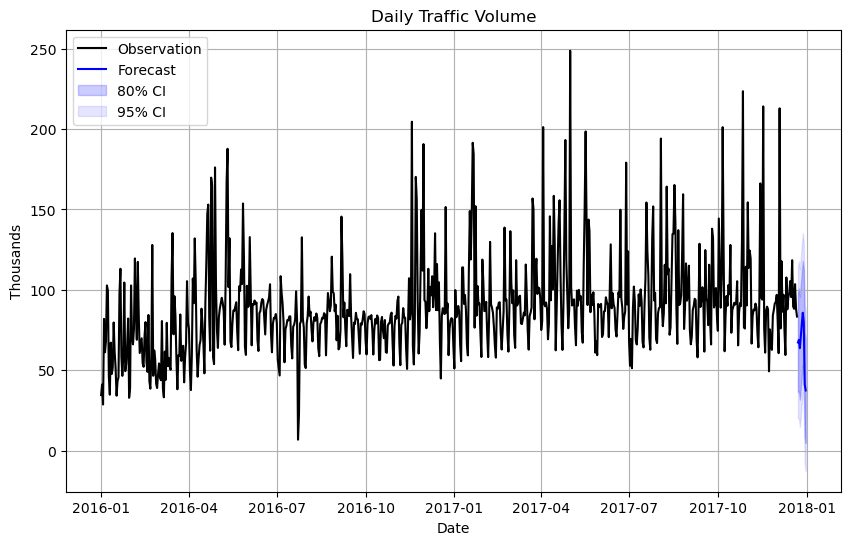

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df_daily["traffic_volume"][:-9], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('Thousands')
plt.title('Daily Traffic Volume')
plt.grid(True)
plt.legend()
plt.show()

## 예제 8-2. VAR 모델 예시

### 미국 가처분 소득 변화와 실질 소비 변화 데이터 VAR 모델 적합 후 예측

#### 필요한 패키지 불러오기

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기

In [15]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
dpi_cons_quarter = macro_econ_data[['realdpi', 'realcons']]
dpi_cons_quarter.index = pd.date_range(start='1959/01/01', end='2009/09/30', freq='3MS')
dpi_cons_quarter

,realdpi,realcons
1959-01-01,1886.9,1707.4
1959-04-01,1919.7,1733.7
1959-07-01,1916.4,1751.8
1959-10-01,1931.3,1753.7
1960-01-01,1955.5,1770.5
...,...,...
2008-07-01,9838.3,9267.7
2008-10-01,9920.4,9195.3
2009-01-01,9926.4,9209.2
2009-04-01,10077.5,9189.0


#### 데이터 시각화

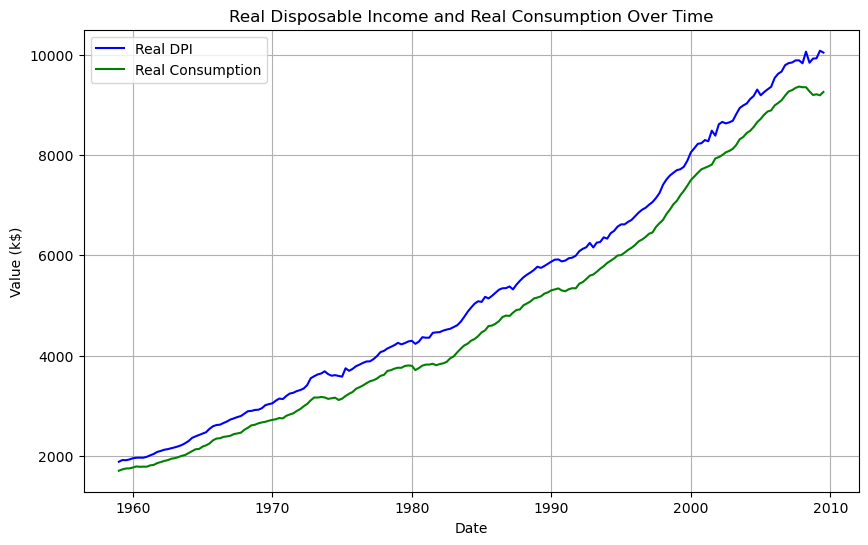

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(dpi_cons_quarter['realdpi'],  color='b', label='Real DPI')
plt.plot(dpi_cons_quarter['realcons'],  color='g', label='Real Consumption')
plt.xlabel("Date")
plt.ylabel("Value (k$)")
plt.title("Real Disposable Income and Real Consumption Over Time")
plt.grid(True)
plt.legend()
plt.show()

#### 1차 차분 데이터 시각화

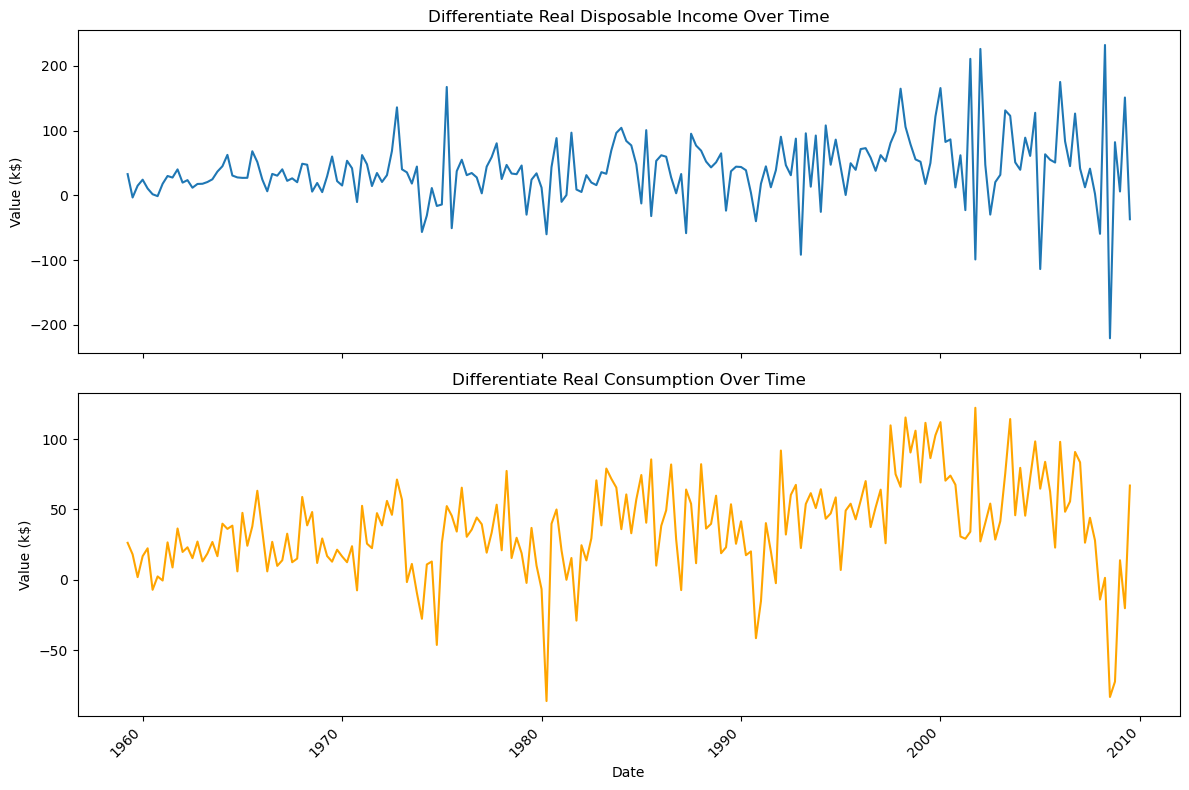

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realdpi'].diff()[1:], label='Real DPI')
ax1.set_ylabel('Value (k$)')
ax1.set_title('Differentiate Real Disposable Income Over Time')

ax2.plot(dpi_cons_quarter['realcons'].diff()[1:], label='Real Consumption', color='orange')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Differentiate Real Consumption Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

#### Adfuller test

In [18]:
print(adfuller(dpi_cons_quarter['realdpi'].diff()[1:][:180])[1])
print(adfuller(dpi_cons_quarter['realcons'].diff()[1:][:180])[1])

1.1698513528678898e-11
0.005911782900179311


#### VAR 파라미터 최적화 함수

In [19]:
def VAR_optimizer(series):
    result= []
    for p in range(10):
        try:
            model = VARMAX(series, order=(p, 0)).fit(dips=False)
        except:
            continue

        aic = model.aic
        result.append([p, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

#### VAR 파라미터 최적화

In [20]:
result = VAR_optimizer(dpi_cons_quarter.diff()[1:][:180])
result

,p,AIC
0,3,3527.479733
1,6,3529.923760
2,4,3531.649738
3,5,3531.862833
4,8,3535.352717
5,7,3536.461965
6,2,3538.155109
7,9,3538.887798
8,1,3540.649008


#### VAR 파라미터 최적화 시각화

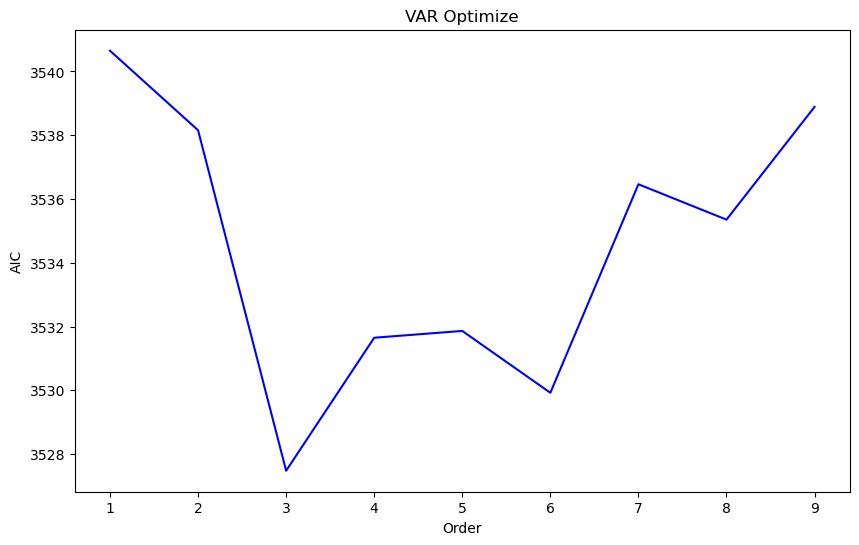

In [21]:
result = result.sort_values(by='p', ascending=True).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(result['p'], result['AIC'], color='b', )
plt.xlabel("Order")
plt.ylabel("AIC")
plt.title("VAR Optimize")
plt.show()

#### 그레인저 인과관계 테스트

In [22]:
print(grangercausalitytests(dpi_cons_quarter[['realdpi', 'realcons']].diff()[1:][:180], [3]))
print(grangercausalitytests(dpi_cons_quarter[['realcons', 'realdpi']].diff()[1:][:180], [3]))


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.9621 , p=0.0000  , df_denom=170, df_num=3
ssr based chi2 test:   chi2=40.4875 , p=0.0000  , df=3
likelihood ratio test: chi2=36.4605 , p=0.0000  , df=3
parameter F test:         F=12.9621 , p=0.0000  , df_denom=170, df_num=3
{3: ({'ssr_ftest': (12.962109059489094, 1.1494011565389592e-07, 170.0, 3), 'ssr_chi2test': (40.487528885815934, 8.398472694334837e-09, 3), 'lrtest': (36.46054468033162, 5.984129087710511e-08, 3), 'params_ftest': (12.962109059489045, 1.1494011565390402e-07, 170.0, 3.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FD920D9D90>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FD93286B50>, array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5517  , p=0.0157  , df_denom=170, df_num=3
ssr ba

#### VAR 모델 적합

In [23]:
model = VARMAX(dpi_cons_quarter.diff()[1:][:180], order=(3, 0))
fit = model.fit()
print(fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  180
Model:                              VAR(3)   Log Likelihood               -1746.740
                               + intercept   AIC                           3527.480
Date:                     Tue, 25 Feb 2025   BIC                           3581.760
Time:                             21:13:20   HQIC                          3549.488
Sample:                         04-01-1959                                         
                              - 01-01-2004                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.06, 0.00   Jarque-Bera (JB):         31.88, 10.85
Prob(Q):                        0.80, 0.96   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         4.52, 2.45   Skew:                      0.38

#### 가처분 소득 데이터 VAR 모델 적합 후 잔차 확인

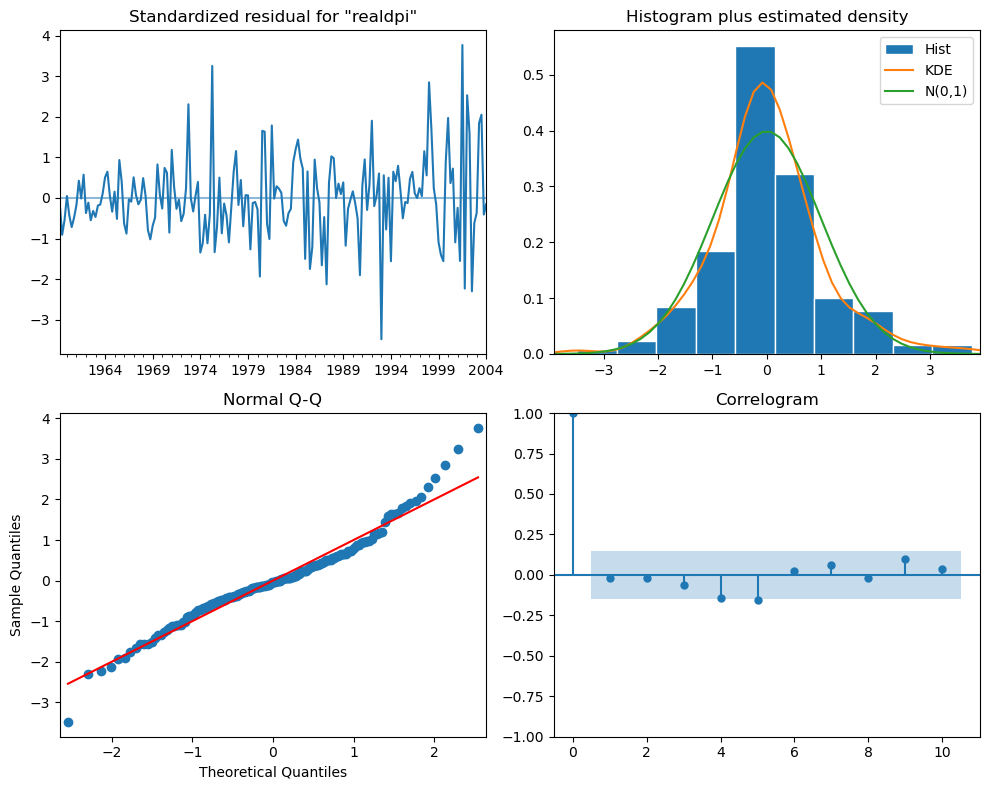

In [24]:
fit.plot_diagnostics(figsize=(10,8), variable=0)
plt.tight_layout()
plt.show()

#### 미국 실질 소비 데이터 VAR 모델 적합 후 잔차 확인

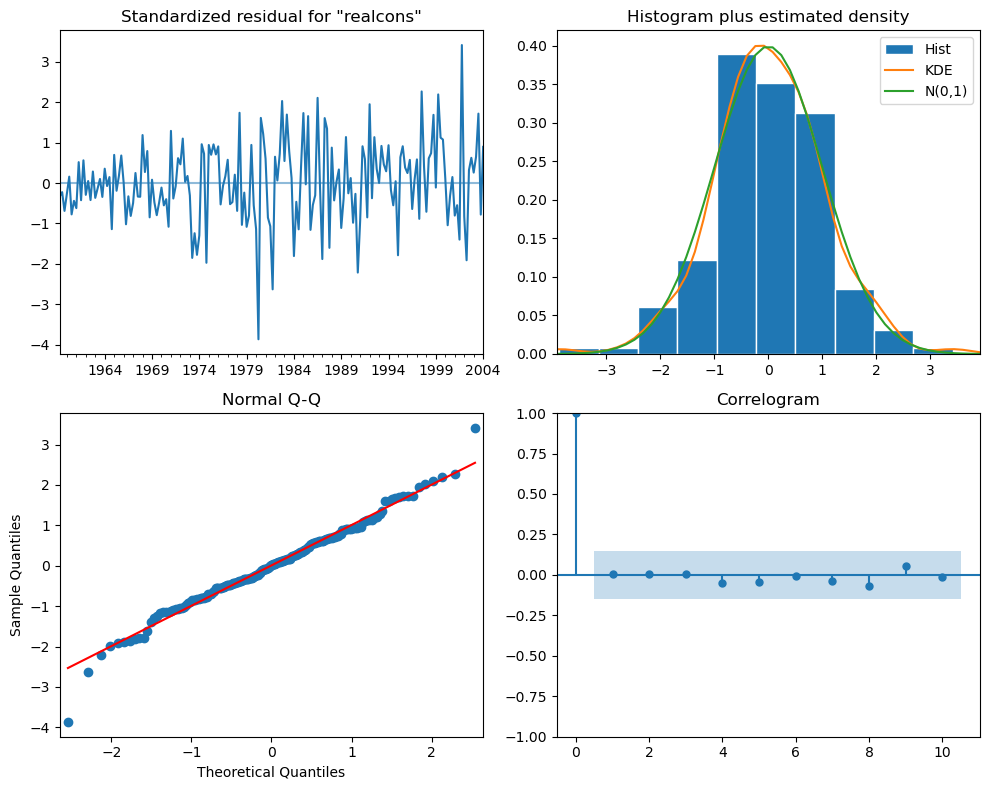

In [25]:
fit.plot_diagnostics(figsize=(10,8), variable=1)
plt.tight_layout()
plt.show()

#### VAR 모델 예측

In [26]:
forecast_result = fit.get_forecast(steps=22)

forecast_mean = forecast_result.predicted_mean
cum_forecast_result = forecast_mean.cumsum()
cum_forecast_result['realdpi'] = cum_forecast_result['realdpi'] + dpi_cons_quarter.iloc[179, 0]
cum_forecast_result['realcons'] = cum_forecast_result['realcons'] + dpi_cons_quarter.iloc[179, 1]

#### 가처분 소득 데이터 신뢰구간

In [27]:
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 2]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 2]

#### 가처분 소득 예측 시각화

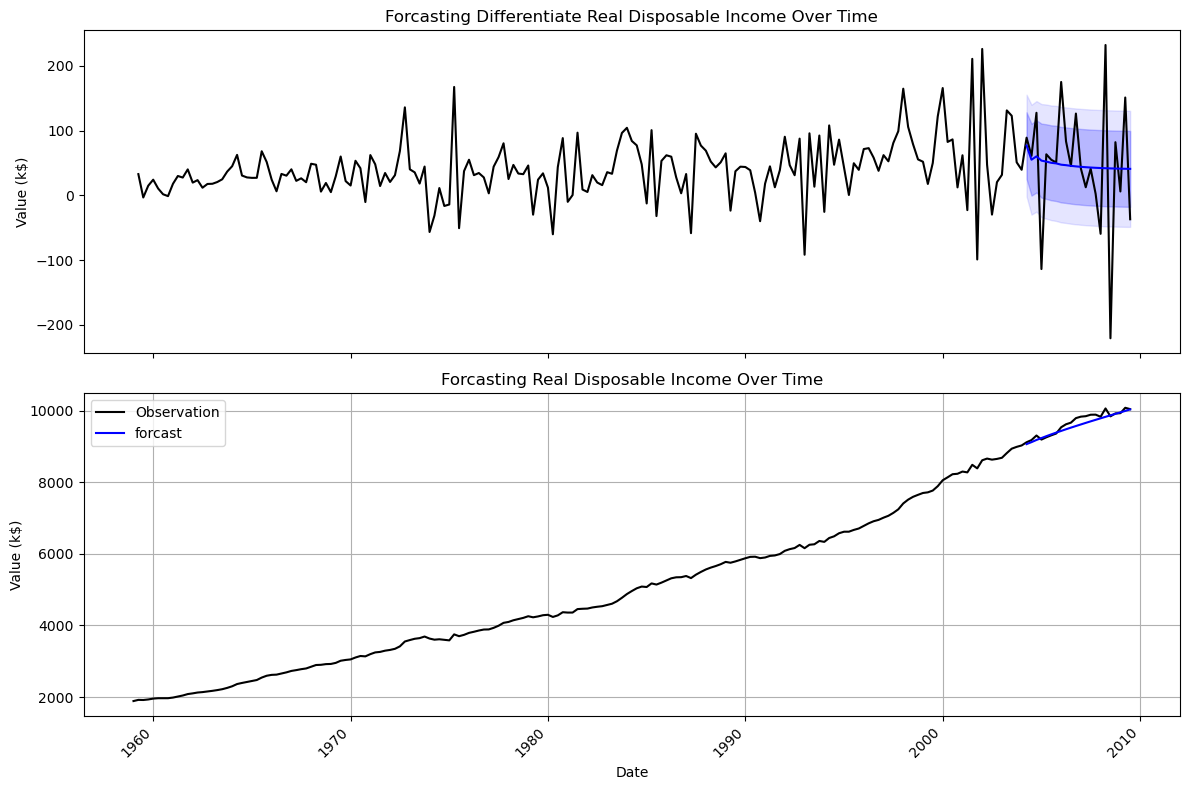

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realdpi'].diff()[1:], label='Observation', color='black')
ax1.plot(forecast_mean['realdpi'], label='forcast', color='b')
ax1.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
ax1.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
ax1.set_ylabel('Value (k$)')
ax1.set_title('Forcasting Differentiate Real Disposable Income Over Time')

ax2.plot(dpi_cons_quarter['realdpi'], label='Observation', color='black')
ax2.plot(cum_forecast_result['realdpi'], label='forcast', color='b')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Forcasting Real Disposable Income Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()

#### 미국 실질소비 소득 데이터 신뢰구간

In [29]:
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 3]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 3]

#### 미국 실질소비 소득 예측 시각화

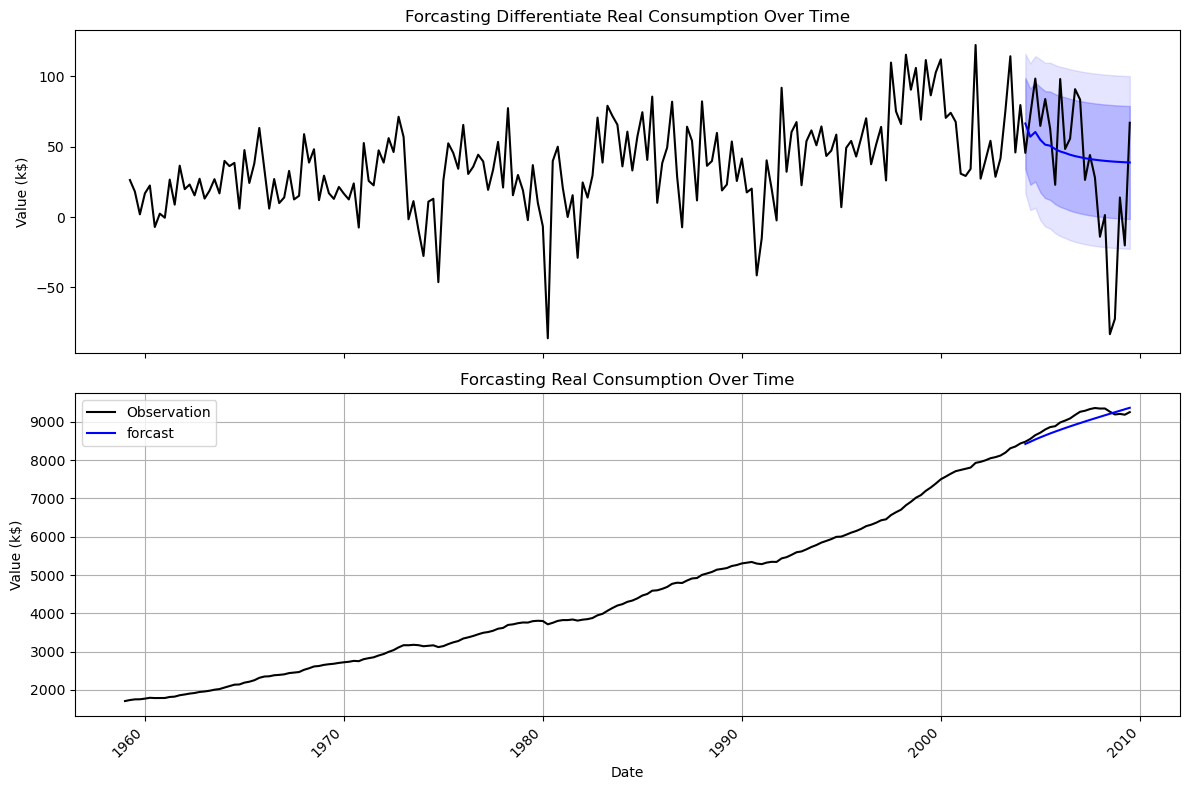

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realcons'].diff()[1:], label='Observation', color='black')
ax1.plot(forecast_mean['realcons'], label='forcast', color='b')
ax1.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
ax1.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
ax1.set_ylabel('Value (k$)')
ax1.set_title('Forcasting Differentiate Real Consumption Over Time')

ax2.plot(dpi_cons_quarter['realcons'], label='Observation', color='black')
ax2.plot(cum_forecast_result['realcons'], label='forcast', color='b')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Forcasting Real Consumption Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()